In [1]:
!pip install pandas_datareader
!pip install --upgrade pandas

In [169]:
import pandas as pd
import datetime as dt
from pandas_datareader import data
import mplfinance as mpf

#apikey = '取得したAPIキー'
apikey = 'KDDTQTNE9OTMD4V4.'
symbol = 'EURUSD'

start = dt.date(2011,1,1)
end = dt.date(2021,1,30)

df = data.DataReader(symbol,'av-daily',start,end, api_key=apikey)

In [170]:
df['volume']=0.1 

array([[<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>],
       [<AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>],
       [<AxesSubplot:title={'center':'volume'}>, <AxesSubplot:>]],
      dtype=object)

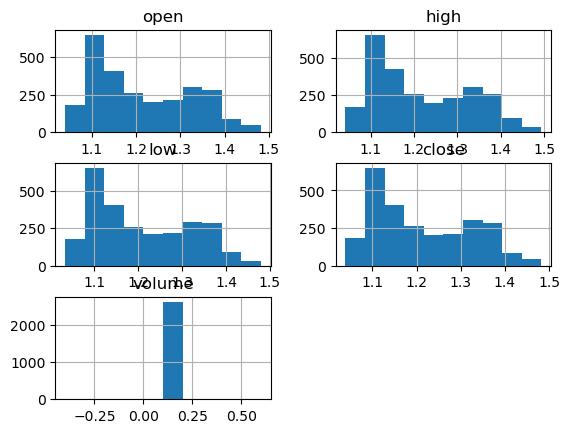

In [171]:
df.hist()

In [172]:
import numpy
#df = df.apply(numpy.log)
from scipy.stats import boxcox
df2,_ = boxcox(df['close'])

In [173]:
df=df.assign(open=df2,high=df2,low=df2,close=df2)

array([[<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>],
       [<AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>],
       [<AxesSubplot:title={'center':'volume'}>, <AxesSubplot:>]],
      dtype=object)

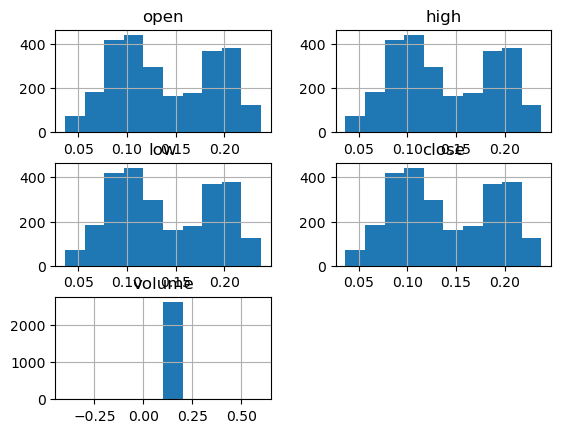

In [174]:
df.hist()

In [175]:
wsize=80 #サンプル期間
after=10 #最終レコード＋α
change_large = 4 #変化大　4%

In [176]:
df.index = pd.DatetimeIndex(df.index)

alldata =[]

for time in range(len(df)-wsize-1):
    try:
        dfspan = df[time:time+wsize]
        dflast = df.at[df.index[time+wsize], 'close']
        dfafter = df.at[df.index[time+wsize+after], 'close']
        changerate=(dfafter-dflast)/dflast*100#変化率
    
        if changerate>0:
            if changerate>change_large:
                dflabel="++"
#            elif changerate>change_small:
#                dflabel="+"
            else:
                dflabel="0"
        else:
            if changerate*-1>change_large:
                dflabel="--"
#            elif changerate*-1>change_small:
#                dflabel="-"
            else:
                dflabel="0"
        alldata.append({"df":dfspan,"label":dflabel})
    except:
        pass

In [177]:
import os
# Path to the train folder
new_dir_path = './train/'
for i in ['--','0','++']:
    os.mkdir(new_dir_path+"/"+i)

In [184]:
import tqdm
import matplotlib as mpl

sma_s= 15
sma_m= 30

cs  = mpf.make_mpf_style(base_mpl_style='dark_background',gridcolor="#000000",mavcolors=['#00ff00','#0000ff'], facecolor="#000000")

for i in tqdm.tqdm(range(len(alldata))):
    mpf.plot(alldata[i]['df'],savefig= new_dir_path + alldata[i]['label']+ '/'\
             + str(i) + 'test.png',mav=(sma_s,sma_m),figsize=(2.5,2.5), type='line',\
             figratio=(12,4),style=cs,axisoff=True,\
             linecolor='#ff0000',tight_layout=True)


100%|██████████████████████████████████████████████████████████████████████████████| 2540/2540 [03:12<00:00, 13.21it/s]


In [185]:
class ImageTransform():
  def __init__(self, mean, std):
    self.data_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

  def __call__(self, img):
    return self.data_transform(img)

In [186]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder

#画像データをImageFolderを使って取込みする
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

images = ImageFolder( new_dir_path, transform = ImageTransform(mean, std))

In [187]:
import torch.utils.data as data

#1バッチに含む画像の枚数を指定する
batch_size = 64

#ImageFolderで取り込んだ画像からデータローダーを作成する
train_dataloader = data.DataLoader(images, batch_size = batch_size, shuffle = True)

In [188]:
#データローダから、画像とラベルのテンソルを取り出す。
imgs, labels = iter(train_dataloader).next()

#バッチから取り出した画像の大きさを確認する
print("image shape ==>;",imgs[0].shape)

image shape ==>; torch.Size([3, 224, 224])


Label is  0


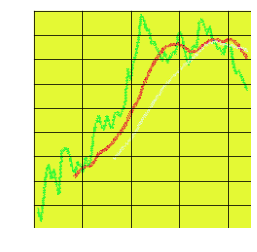

In [189]:
import matplotlib.pyplot as plt
%matplotlib inline

#バッチから取り出した画像のイメージとラベルを表示する
pic = transforms.ToPILImage(mode='RGB')(imgs[0])
plt.imshow(pic)
print("Label is ",labels[0].numpy())

Label is  1


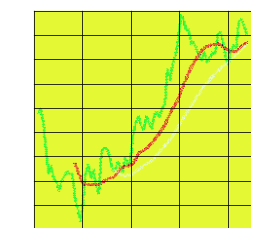

In [190]:
#バッチから取り出した画像のイメージとラベルを表示する
pic = transforms.ToPILImage(mode='RGB')(imgs[63])
plt.imshow(pic)
print("Label is ",labels[63].numpy())

In [191]:
# 学習データ、検証データに 8:2 の割合で分割する。
train_size = int(0.8 * len(images))
val_size = len(images) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    images, [train_size, val_size]
)

In [192]:
#1バッチに含む画像の枚数を指定する
batch_size = 64

#ImageFolderで取り込んだ画像からデータローダーを作成する
dataloaders = {
  'train': data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True),
  'valid': data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
}
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(val_dataset)
}

In [210]:
from torchvision import models, transforms
import torch.nn as nn
vgg16 = models.vgg16(pretrained=True)

# 全結合層の変更(最終層の出力を2にする)
vgg16.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 3),
)

In [213]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# 出力層の変更
#num_ftrs = vgg16.classifier[6].in_features
#vgg16.classifier[6] = torch.nn.Linear(num_ftrs,  out_features=3)

net_ft1 = vgg16.to(device)

# 損失関数および学習パラメーターの定義
criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(net_ft1.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 訓練モードに設定
net_ft1.train()

# ファインチューニングで学習させるパラメータを、変数param_to_updateに格納する
param_to_update_1 = []
param_to_update_2 = []
param_to_update_3 = []

# 学習させるパラメータ名
update_param_names_1 = ['features']
update_param_names_2 = ['classifier.0.weight','classifier.0.bias','classifier.3.weight','classifier.3.bias']
update_param_names_3 = ['classifier.6.weight','classifier.6.bias']



In [214]:
# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name,param in net_ft1.named_parameters():
    print(name)
    if update_param_names_1[0] in name:
        param.requires_grad = True
        param_to_update_1.append(param)
    elif name in update_param_names_2:
        param.requires_grad = True
        param_to_update_2.append(param)
    elif name in update_param_names_3:
        param.requires_grad = True
        param_to_update_3.append(param)
    else:
        param.requires_grad = False

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [216]:
# 最適化手法の設定
optimizer = torch.optim.SGD([
    {'params':param_to_update_1,'lr':1e-4},
    {'params':param_to_update_2,'lr':5e-4},
    {'params':param_to_update_3,'lr':1e-3},
    ],momentum=0.9)

In [217]:
num_epochs = 25
acc_history_ft1 = {'train': [], 'valid': []}

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'valid']:
        if phase == 'train':
            net_ft1.train()
        else:
            net_ft1.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = net_ft1(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        acc_history_ft1[phase].append(epoch_acc)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

Epoch 0/24
----------


C:\Users\User\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 1.0599 Acc: 0.4532
valid Loss: 1.0284 Acc: 0.5098
Epoch 1/24
----------
train Loss: 1.0059 Acc: 0.4921
valid Loss: 0.9664 Acc: 0.5413
Epoch 2/24
----------
train Loss: 0.9482 Acc: 0.5379
valid Loss: 0.9101 Acc: 0.5669
Epoch 3/24
----------
train Loss: 0.8768 Acc: 0.6122
valid Loss: 0.8739 Acc: 0.6220
Epoch 4/24
----------
train Loss: 0.7976 Acc: 0.6629
valid Loss: 0.7610 Acc: 0.6870
Epoch 5/24
----------
train Loss: 0.7197 Acc: 0.6973
valid Loss: 0.7279 Acc: 0.7008
Epoch 6/24
----------
train Loss: 0.6531 Acc: 0.7318
valid Loss: 0.6744 Acc: 0.7087
Epoch 7/24
----------
train Loss: 0.5900 Acc: 0.7589
valid Loss: 0.6834 Acc: 0.7028
Epoch 8/24
----------
train Loss: 0.5379 Acc: 0.7884
valid Loss: 0.6457 Acc: 0.7382
Epoch 9/24
----------
train Loss: 0.4903 Acc: 0.7958
valid Loss: 0.6626 Acc: 0.7480
Epoch 10/24
----------
train Loss: 0.4529 Acc: 0.8214
valid Loss: 0.6655 Acc: 0.7165
Epoch 11/24
----------
train Loss: 0.4123 Acc: 0.8307
valid Loss: 0.6001 Acc: 0.7461
Epoch 12/24


(0.0, 1.0)

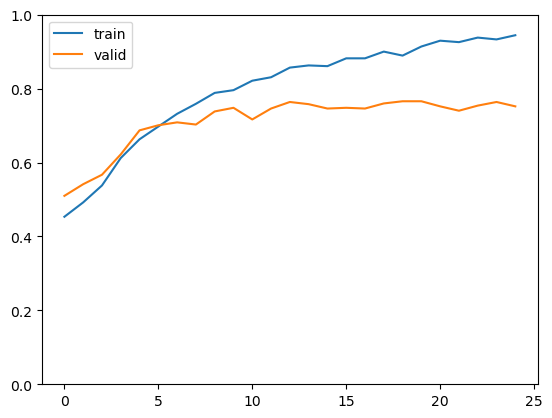

In [218]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('default')


fig = plt.figure()
ax = fig.add_subplot()
ax.plot([a.cpu().numpy() for a in acc_history_ft1['train']], label='train')
ax.plot([a.cpu().numpy() for a in acc_history_ft1['valid']],label='valid')
ax.legend()
ax.set_ylim(0, 1)